# Dimension

While the majority of `momepy` functions require interaction of more `GeoDataFrames` or using spatial weights matrix, there are some which are calculated on single `GeoDataFrame` assessing the dimensions or shapes of features. This notebook illustrates this group on small part of Manhattan, New York.

In [1]:
import momepy
import geopandas as gpd
import matplotlib.pyplot as plt

We will again use `osmnx` to get the data for our example and after preprocessing of building layer will generate tessellation. You can show the code with the button on the right side.

In [11]:
import osmnx as ox

point = (40.731603, -73.977857)
dist = 1000
gdf = ox.geometries.geometries_from_point(point, dist=dist, tags={'building':True})
gdf_projected = ox.projection.project_gdf(gdf)
gdf_projected = gdf_projected[gdf_projected.geom_type.isin(['Polygon', 'MultiPolygon'])]

buildings = momepy.preprocess(gdf_projected, size=30,
                              compactness=True, islands=True)
buildings['uID'] = momepy.unique_id(buildings)
limit = momepy.buffered_limit(buildings)
tess = momepy.Tessellation(buildings, unique_id='uID', limit=limit)
tessellation = tess.tessellation

/opt/miniconda3/envs/test/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Inward offset...
Discretization...


 10%|▉         | 83/836 [00:00<00:00, 824.76it/s]

Generating input point array...


100%|██████████| 836/836 [00:01<00:00, 569.30it/s]


Generating Voronoi diagram...
Generating GeoDataFrame...


Vertices to Polygons: 100%|██████████| 356875/356875 [00:06<00:00, 55758.92it/s]


Dissolving Voronoi polygons...


100%|██████████| 3/3 [00:00<00:00, 1068.43it/s]

Preparing limit for edge resolving...
Building R-tree...
Identifying edge cells...
Cutting...


/opt/miniconda3/envs/test/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


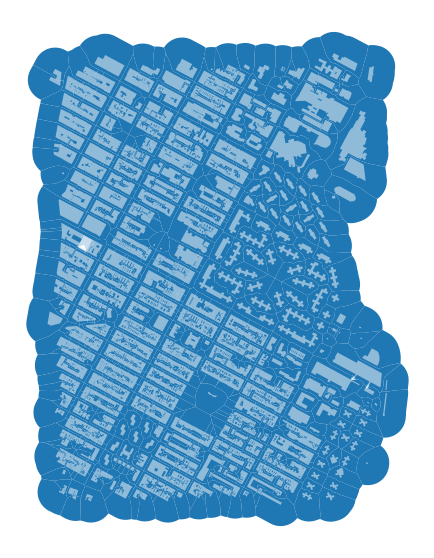

In [12]:
f, ax = plt.subplots(figsize=(10, 10))
tessellation.plot(ax=ax)
buildings.plot(ax=ax, color='white', alpha=.5)
ax.set_axis_off()
plt.show()

We have some edge effect here as we are using the buffer as a limit for tessellation in the middle of urban fabric, but for this examples we can work with it anyway.

## Area
Some work the same for more elements (buildings, tessellation, plots) like area, some makes sense only for a relevant ones. Area works for both, buildings and tessellation of our case study.

Resulting values can be accessed using `area` attribute, while original gdf using `gdf`.

In [4]:
blg_area = momepy.Area(buildings)
buildings['area'] = blg_area.series

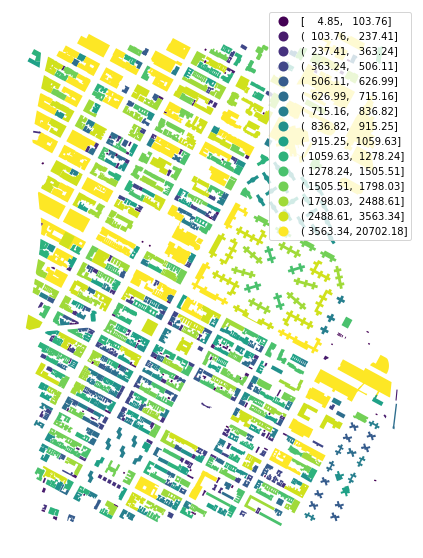

In [5]:
f, ax = plt.subplots(figsize=(10, 10))
buildings.plot(ax=ax, column='area', legend=True, scheme='quantiles', k=15, cmap='viridis')
ax.set_axis_off()
plt.show()

In [6]:
tes_area = momepy.Area(tessellation)
tessellation['area'] = tes_area.series

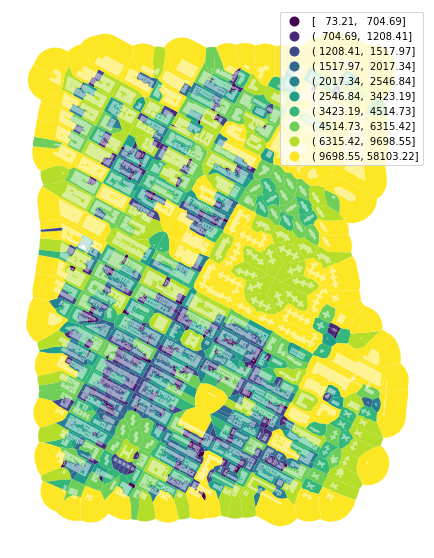

In [7]:
f, ax = plt.subplots(figsize=(10, 10))
tessellation.plot(ax=ax, column='area', legend=True, scheme='quantiles', k=10, cmap='viridis')
buildings.plot(ax=ax, color='white', alpha=0.5)
ax.set_axis_off()
plt.show()

## Height

We can also work with building heights (if we have the data). This part of New York has height data, only stored as strings, so we have to convert them to `floats` (or `int`) and fill `NaN` values with zero. Since some height attrbutes may be incorrectly defined in OSM, we use try/except to filter potential issues.

In [8]:
def clean_heights(x):
    try:
        return float(x)
    except ValueError:
        return 0

buildings['height'] = buildings['height'].fillna(0).apply(clean_heights)

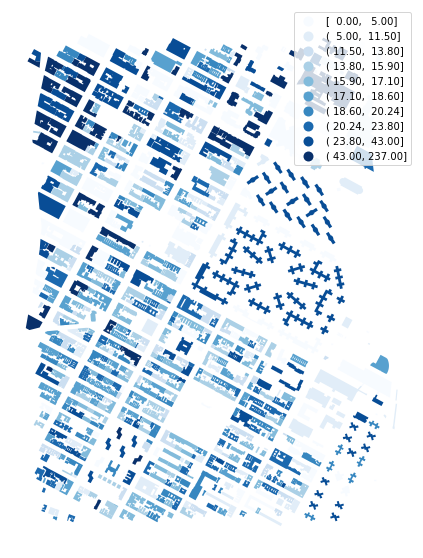

In [9]:
f, ax = plt.subplots(figsize=(10, 10))
buildings.plot(ax=ax, column='height', scheme='quantiles', k=10, legend=True, cmap='Blues')
ax.set_axis_off()
plt.show()

There are not many simple characters we can do with height, but `Volume` is possible. Unlike before, you have to pass the name of the column, `np.array`, or `pd.Series` where is stored height value. We have a column already.

In [10]:
blg_volume = momepy.Volume(buildings, heights='height')
buildings['volume'] = blg_volume.series

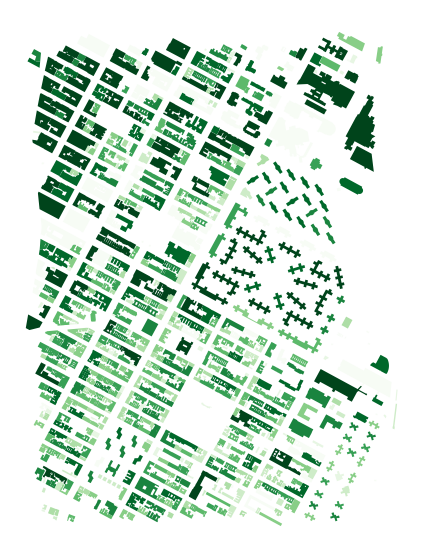

In [11]:
f, ax = plt.subplots(figsize=(10, 10))
buildings.plot(ax=ax, column='volume', legend=False, scheme='quantiles', k=10, cmap='Greens')
ax.set_axis_off()
plt.show()

Overview of all characters is available in [API](https://docs.momepy.org/en/latest/api.html), with additional examples of usage. Some characters make sense to calculate only in specific cases. Prime example is `CourtyarArea` - there are many places where all buildings are courtyard-less, resulting in a `Series` full of zeros.